# Language Model - Sentiment Analysis

This notebook implements ideas and exercises from Lesson 10 of fast.ai's Deep Learning 2 course (2018 Version), documenting an approach to sentiment analysis utilizing transfer learning based on a language model.


* **Author**: ksferguson (K. Scott Ferguson)
* **Type**: Deep Learning
* **Stack**: fast.ai over pyTorch
* **Pattern**: Language Model & Sentiment Classification
* **Problem**: Identify whether IMDB review is positive or negative in sentiment
* **Dataset**: IMDB



Status: In Progress
  1. Multi-epoch fine-tuning of Wikitext103 with the IMDB reviews did not produce much results (cf. Jeremy's original notebook), need to review and find the issue.
  2. Final Training of Sentiment Classifier yields decent 93.4% results, but suggests overfitting, need to add more regularization (back) in. This may be related to #1 above.

## fast.ai General Approach

A. Utilize Transfer Learning whenever possible

B. Start simple, then use stepwise refinement

C. Train to Overfitting, then tweak back

1. Add (more) Data
2. Add (more) Data Augmentation
3. Add (more) Batch Normalization
4. Add (more) Regularization (Dropout, Weight Decay)
5. Reduce model complexity

### General Setup

* fast.ai PaperSpace Setup Notes: https://gist.github.com/ksferguson/0b384e892689617d1539d35c1254eb01
* Ubuntu Setup Notes for Dell 7559 with GTX 960M: https://gist.github.com/ksferguson/a6eba79df658826cacb629dcc14992eaPaperSpace


In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
#superset of imports
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import pandas as pd
#torch.cuda.set_device(0)

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

### Data

Download http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz into PATH location and untar.

In [5]:
from fastai.text import *

In [6]:
PATH = Path('data/aclIMDB')

In [7]:
BOS = 'xbos'    #beginning of sentence
FLD = 'xfld'    #data field  (within doc)

In [8]:
CLAS_PATH = PATH/'clas'
LM_PATH = PATH/'lm'

In [9]:
CLASSES = ['neg', 'pos', 'unsup']

def get_texts(path):
    texts,labels = [],[]
    for idx,label in enumerate(CLASSES):
        print(path/label)
        for fname in (path/label).glob('*.*'):
            texts.append(fname.open('r').read())
            labels.append(idx)
    return np.array(texts), np.array(labels)

trn_texts, trn_labels = get_texts(PATH/'train')
val_texts, val_labels = get_texts(PATH/'test')


data/aclIMDB/train/neg
data/aclIMDB/train/pos
data/aclIMDB/train/unsup
data/aclIMDB/test/neg
data/aclIMDB/test/pos
data/aclIMDB/test/unsup


In [10]:
len(trn_texts), len(val_texts)

(75000, 25000)

In [11]:
np.random.seed(42)
trn_idx =np.random.permutation(len(trn_texts))
val_idx =np.random.permutation(len(val_texts))

In [12]:
trn_texts = trn_texts[trn_idx]
val_texts = val_texts[val_idx]

trn_labels = trn_labels[trn_idx]
val_labels = val_labels[val_idx]

In [13]:
df_trn = pd.DataFrame({'text': trn_texts, 'labels': trn_labels}, columns=['labels', 'text'])
df_val = pd.DataFrame({'text': val_texts, 'labels': val_labels}, columns=['labels', 'text'])

In [14]:
df_trn[df_trn['labels']!=2].to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'test.csv', header=False, index=False)

In [15]:
(CLAS_PATH/'classes.txt').open('w').writelines(f'{o}\n' for o in CLASSES)

Prep data for Language Model

In [16]:
trn_texts, val_texts = sklearn.model_selection.train_test_split(
    np.concatenate([trn_texts, val_texts]), test_size=0.1)

In [17]:
len(trn_texts), len(val_texts)

(90000, 10000)

In [18]:
df_trn = pd.DataFrame({'text': trn_texts, 'labels': [0]*len(trn_texts)}, columns=['labels', 'text'])
df_val = pd.DataFrame({'text': val_texts, 'labels': [0]*len(val_texts)}, columns=['labels', 'text'])
df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False)

### Language Model Cleanup

Tokenize w spaCy.

In [19]:
chunksize = 24000
import html

In [20]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', '\n').replace('quot;', "'").replace(
        '<br />', '\n').replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [21]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:, range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)
    
    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [22]:
def get_all(df, n_lbls):
    tok, labels = [],[]
    for i,r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_
        labels += labels_
    return tok, labels

In [23]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

In [24]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
3
0


In [25]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [26]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [27]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [28]:
freq = Counter(p for o in tok_trn for p in o)

In [29]:
freq.most_common(25)

[('the', 1208449),
 ('.', 992545),
 (',', 986614),
 ('and', 587567),
 ('a', 583520),
 ('of', 525412),
 ('to', 484871),
 ('is', 393923),
 ('it', 341485),
 ('in', 337351),
 ('i', 307751),
 ('this', 270410),
 ('that', 261107),
 ('"', 237920),
 ("'s", 222037),
 ('-', 188209),
 ('was', 180235),
 ('\n\n', 179009),
 ('as', 166145),
 ('with', 159253),
 ('for', 158601),
 ('movie', 157735),
 ('but', 150659),
 ('film', 144618),
 ('you', 123979)]

In [30]:
max_vocab = 60000
min_freq = 2

In [31]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]

In [32]:
itos.insert(0, '_pad_') 
itos.insert(0, '_unk_') 


In [33]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [34]:
len(stoi)

60002

In [35]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [36]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [37]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [38]:
vs = len(itos)
vs, len (trn_lm)

(60002, 90000)

### wikitext103 Model

In [39]:
em_sz, nh, nl = 400, 1150, 3

In [40]:
PRE_PATH = PATH/'models'/'wt103'

In [41]:
PRE_LM = PRE_PATH/'fwd_wt103.h5'

In [42]:
wgts = torch.load(PRE_LM, map_location=lambda storage, loc: storage)

In [43]:
enc_wgts = to_np(wgts['0.encoder.weight'])

In [44]:
row_mean = enc_wgts.mean(0)

In [45]:
row_mean[:12]

array([-0.0183 , -0.13826,  0.01438, -0.01285,  0.00407,  0.01944,  0.01149, -0.13282, -0.02295, -0.01722,
        0.02994,  0.00921], dtype=float32)

In [46]:
itos2 =pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))

In [47]:
stoi2 =collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [48]:
itos2[:12]

['_unk_', '_pad_', 'the', ',', '.', 'of', 'and', 'in', 'to', 'a', '=', '"']

In [49]:
stoi2['_pad_']; stoi2['in']

7

In [50]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_mean

In [51]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

## Language Model

In [52]:
#prep model params
wd = 1e-7    #weight decay
bptt = 70    #back prop thru time - ~length of max sequence for back prop
bs = 52      #mini-batch size
opt_fn = partial (optim.Adam, betas=(0.8, 0.99))    #optimization function

In [53]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [54]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7; drops

array([0.175, 0.07 , 0.14 , 0.014, 0.105])

In [55]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
        dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

In [56]:
learner.metrics = [accuracy]
learner.freeze_to(-1)

In [57]:
learner.model.load_state_dict(wgts)

In [58]:
wgts['0.encoder.weight'].shape

torch.Size([60002, 400])

In [59]:
lr = 1e-3

In [60]:
lrs = lr

In [61]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      4.66798    4.440529   0.258234  



[array([4.44053]), 0.2582343826534867]

In [62]:
learner.save('lm_last_ft')

In [63]:
learner.load('lm_last_ft')

In [64]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy                     
    0      4.757163   4.509839   0.250007  



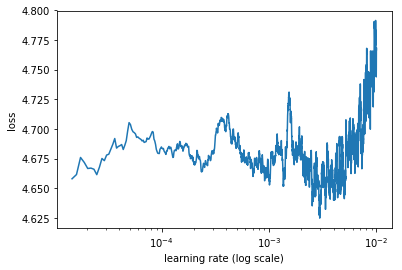

In [65]:
learner.sched.plot()

In [67]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

epoch      trn_loss   val_loss   accuracy                     
    0      4.608152   4.392202   0.26132   
    1      4.557162   4.353957   0.262978                     
    2      4.532704   4.342091   0.263604                     
    3      4.519836   4.337015   0.263697                     
    4      4.516223   4.334932   0.263709                     
    5      4.510143   4.333782   0.263888                     
    6      4.531183   4.33364    0.263633                     
    7      4.511115   4.333348   0.26366                      
    8      4.501187   4.332601   0.263737                     
    9      4.509573   4.332639   0.263618                     
    10     4.522011   4.332589   0.263766                     
    11     4.527513   4.332322   0.263758                     
    12     4.514414   4.33228    0.263904                     
    13     4.50325    4.332044   0.263839                     
    14     4.493759   4.330528   0.264191                     



[array([4.33053]), 0.26419087667555946]

In [68]:
learner.save('lm1')

In [69]:
learner.save_encoder('lm1_enc')

Classifier Tokens

In [70]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [71]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
0
1


In [74]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [75]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [76]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [77]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [78]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

### Classifier

In [80]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [81]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [82]:
bptt,em_sz,nh,nl = 70,400,1150,3

In [83]:
vs= len(itos)

In [84]:
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [85]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c = int(trn_labels.max())+1

In [88]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))

In [91]:
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)

In [92]:
md = ModelData(PATH, trn_dl, val_dl)

In [121]:
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1]) * 0.8

In [122]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
    layers=[em_sz*3, 50, c], drops=[dps[4], 0.1], dropouti=dps[0], 
    wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [123]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [124]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip = 25.
learn.metrics = [accuracy]

In [130]:
lr=3e-3
lrm=2.6
lrs=np.array([lr/(lrm**4),lr/(lrm**3),lr/(lrm**2),lr/lrm,lr])
#lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [131]:
wd = 1e-7
wd = 0 

In [132]:
learn.load_encoder('lm1_enc')
learn.freeze_to(-1)

 79%|███████▉  | 824/1042 [02:11<00:34,  6.25it/s, loss=1.89] 

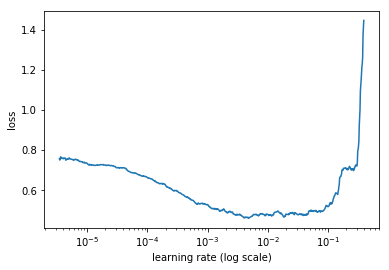

In [133]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [134]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                      
    0      0.481251   0.320939   0.86472   


[array([0.32094]), 0.8647199995422363]

In [135]:
learn.save('clas_0')

In [136]:
learn.load('clas_0')

In [137]:
learn.freeze_to(-2)

In [138]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                      
    0      0.412923   0.26973    0.89304   


[array([0.26973]), 0.8930400004196167]

In [139]:
learn.save('clas_1')

In [140]:
learn.load('clas_1')

In [141]:
learn.unfreeze()

first run through reached 93.3% but started overfitting by epoch 5, going back & increasing dropout

In [142]:
learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                      
    0      0.331624   0.252037   0.90224   
    1      0.277779   0.19373    0.92584                       
    2      0.222563   0.18802    0.93164                       
    3      0.195846   0.182025   0.93452                       
    4      0.201302   0.173277   0.93888                       
    5      0.18083    0.2394     0.9396                        
    6      0.164528   0.177689   0.93804                       
    7      0.152496   0.209225   0.93892                       
    8      0.134895   0.181803   0.93844                       
    9      0.14474    0.180355   0.94032                       
    10     0.133785   0.188599   0.94028                       
    11     0.126483   0.18403    0.94132                       
    12     0.110195   0.203779   0.94044                        
    13     0.098394   0.193113   0.93988                        


[array([0.19311]), 0.9398800002479554]